In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

./dataset\Beagle\Beagle_1.jpg
./dataset\Boxer\Boxer_1.jpg
./dataset\Bulldog\Bulldog_1.jpg
./dataset\Dachshund\Dachshund_1.jpg
./dataset\German_Shepherd\German Shepherd_1.jpg
./dataset\Golden_Retriever\Golden Retriever_1.jpg
./dataset\Labrador_Retriever\Labrador Retriever_1.jpg
./dataset\Poodle\Poodle_1.jpg
./dataset\Rottweiler\Rottweiler_1.jpg
./dataset\Yorkshire_Terrier\Yorkshire Terrier_1.jpg


In [71]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

IMAGE_SIZE = [224,224]
dataset_path = './dataset'

## Train Test Splitting

splitting the dataset into train and validation sets

In [72]:
from sklearn.model_selection import train_test_split
import os
import shutil
import random

# Set your dataset directory
dataset_dir = './dataset'

# Define directories for train and validation sets
train_dir = './train'
valid_dir = './valid'

# Create train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# List all subdirectories (assuming each subdirectory represents a class)
classes = os.listdir(dataset_dir)

# Create class directories in train and validation directories
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, cls), exist_ok=True)
    
# Split and copy images to train and validation directories
for cls in classes:
    # Get all images in the current class directory
    images = os.listdir(os.path.join(dataset_dir, cls))
    
    # Split images into train and validation sets
    train_images, valid_images = train_test_split(images, test_size=0.2, stratify=[cls]*len(images), random_state=42)
    
    # Copy images to respective directories
    for img in train_images:
        src = os.path.join(dataset_dir, cls, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
        
    for img in valid_images:
        src = os.path.join(dataset_dir, cls, img)
        dst = os.path.join(valid_dir, cls, img)
        shutil.copyfile(src, dst)


## Data Augmentation

In [73]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [74]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 771 images belonging to 10 classes.
Found 196 images belonging to 10 classes.


In [75]:
print(len(training_set))
print(len(test_set))

25
7


## 3 Models for now

**1. Inception Model**

In [76]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def inception_model(image_shape = IMAGE_SIZE):

    input_shape = image_shape + [3]

    base_model = InceptionV3(input_shape=IMAGE_SIZE + [3],
                              weights='imagenet',
                              include_top=False)
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    x = base_model.input

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 

    x = GlobalAveragePooling2D()(x)

    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)

    x = Dense(1024, activation='relu')(x)

    predictions = Dense(len(classes), activation='softmax')(x)

    model = Model(base_model.input, predictions)

    return model

In [77]:
def vgg16_model(image_shape = IMAGE_SIZE):

    input_shape = image_shape + [3]

    base_model = VGG16(input_shape=IMAGE_SIZE + [3],
                              weights='imagenet',
                              include_top=False)
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    x = base_model.input

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 

    x = GlobalAveragePooling2D()(x)

    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)

    x = Dense(1024, activation='relu')(x)

    predictions = Dense(len(classes), activation='softmax')(x)

    model = Model(base_model.input, predictions)

    return model, base_model

In [78]:
def resnet50_model(image_shape = IMAGE_SIZE):

    input_shape = image_shape + [3]

    base_model = ResNet50(input_shape=IMAGE_SIZE + [3],
                              weights='imagenet',
                              include_top=False)
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    x = base_model.input

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 

    x = GlobalAveragePooling2D()(x)

    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)

    x = Dense(1024, activation='relu')(x)

    predictions = Dense(len(classes), activation='softmax')(x)

    model = Model(base_model.input, predictions)

    return model

In [79]:
inception = inception_model()
vgg16, base_model_vgg = vgg16_model()
resnet50 = resnet50_model()

In [80]:
base_learning_rate = 0.01

In [81]:
inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
initial_epochs = 5

In [83]:
history_inception = inception.fit(training_set, validation_data=test_set, epochs=initial_epochs)

Epoch 1/5


C:\Users\anshu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 911ms/step - accuracy: 0.5868 - loss: 2.0299 - val_accuracy: 0.9388 - val_loss: 0.1238
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accuracy: 0.9597 - loss: 0.1251 - val_accuracy: 0.9898 - val_loss: 0.0266
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 711ms/step - accuracy: 0.9782 - loss: 0.0724 - val_accuracy: 0.9898 - val_loss: 0.0227
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - accuracy: 0.9775 - loss: 0.0626 - val_accuracy: 0.9898 - val_loss: 0.0281
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.9850 - loss: 0.0515 - val_accuracy: 0.9898 - val_loss: 0.0226


In [84]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):

    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

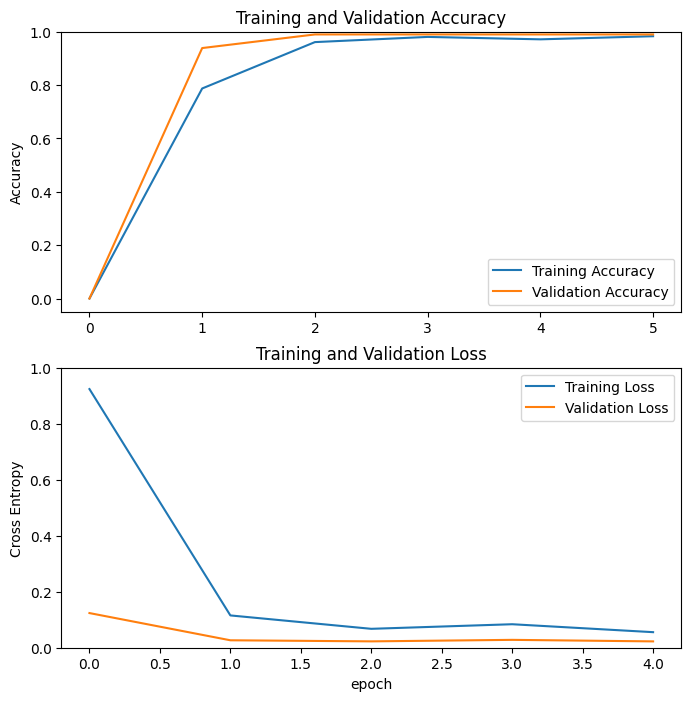

In [85]:
plot_accuracy_loss(history_inception)

In [86]:
history_vgg16 = vgg16.fit(training_set, validation_data=test_set, epochs=initial_epochs)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1374 - loss: 2.4743 - val_accuracy: 0.2551 - val_loss: 2.0731
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3158 - loss: 2.0047 - val_accuracy: 0.4949 - val_loss: 1.7571
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.4560 - loss: 1.7421 - val_accuracy: 0.6327 - val_loss: 1.4831
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5468 - loss: 1.4660 - val_accuracy: 0.6735 - val_loss: 1.3018
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5933 - loss: 1.2769 - val_accuracy: 0.6173 - val_loss: 1.2064


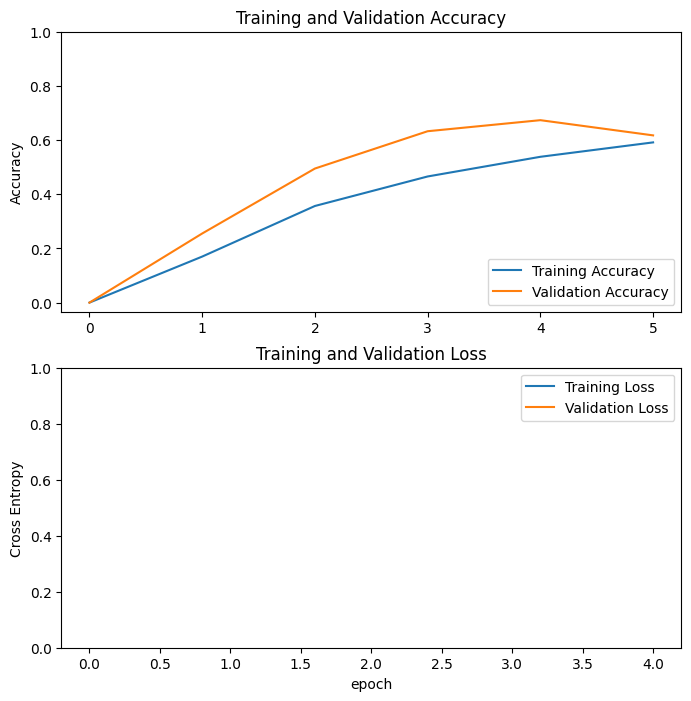

In [87]:
plot_accuracy_loss(history_vgg16)

In [88]:
history_resnet50 = resnet50.fit(training_set, validation_data=test_set, epochs=initial_epochs)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1242 - loss: 2.7186 - val_accuracy: 0.0969 - val_loss: 2.4200
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1131 - loss: 2.3949 - val_accuracy: 0.1276 - val_loss: 2.3322
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1283 - loss: 2.3530 - val_accuracy: 0.1990 - val_loss: 2.2836
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1350 - loss: 2.3695 - val_accuracy: 0.1582 - val_loss: 2.2377
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1594 - loss: 2.2852 - val_accuracy: 0.2194 - val_loss: 2.2303


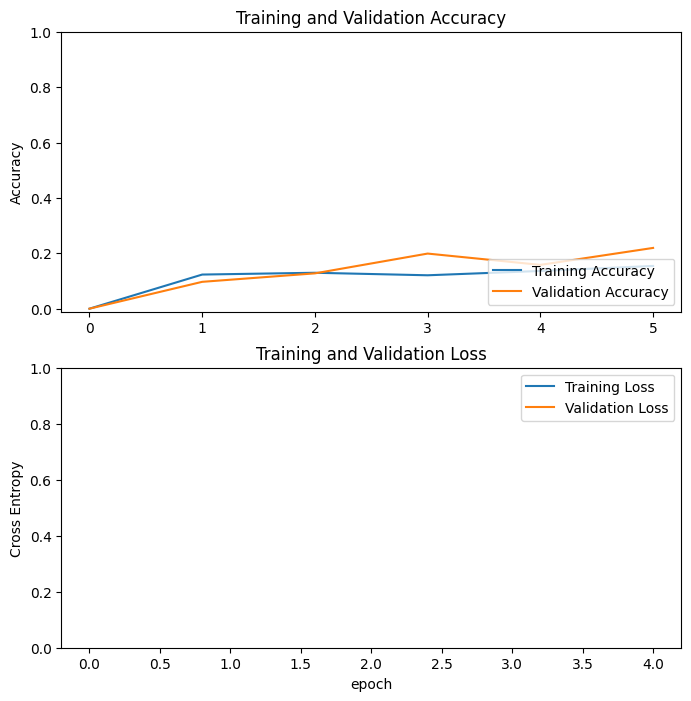

In [89]:
plot_accuracy_loss(history_resnet50)

## Fine Tuning


In [90]:
base_model_vgg.trainable = True

print("Number of layers in the base model: ", len(base_model_vgg.layers))

Number of layers in the base model:  19


In [91]:
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_vgg.layers[:fine_tune_at]:
    print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False

optimizer = Adam(learning_rate=0.001)


vgg16.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])


fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = vgg16.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history_vgg16.epoch[-1],
                         validation_data=test_set)

Layer input_layer_13 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.1768 - loss: 95.0860 - val_accuracy: 0.1020 - val_loss: 2.3027
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.0780 - loss: 2.5244 - val_accuracy: 0.0969 - val_loss: 2.3027
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.1014 - loss: 2.3628 - val_accuracy: 0.1020 - val_loss: 2.3025
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.0981 - loss: 2.3032 - val_accuracy: 0.1020 - val_loss: 2.3025
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.1241 - loss: 2.3012 - val_accuracy: 0.1020 - val_loss: 2.3024
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.0935 - loss: 2.3029 - val_ac

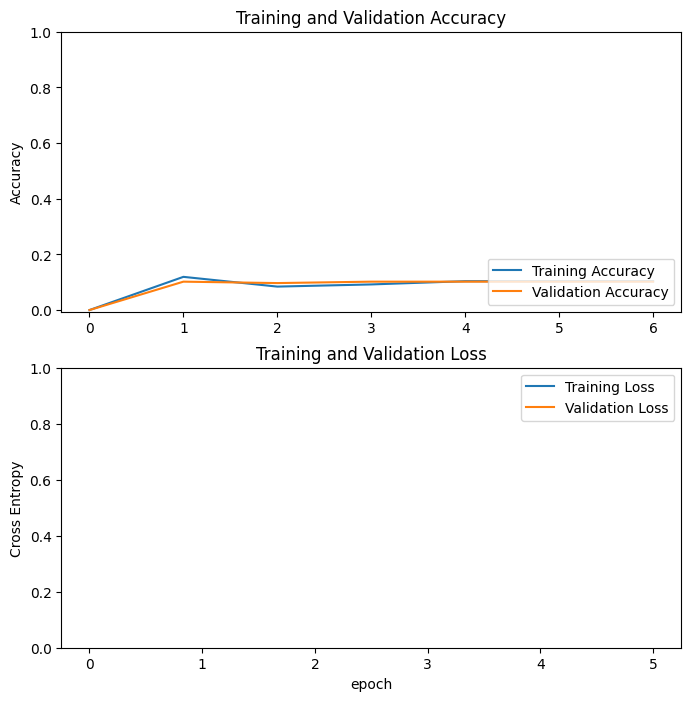

In [92]:
plot_accuracy_loss(history_fine)

In [93]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

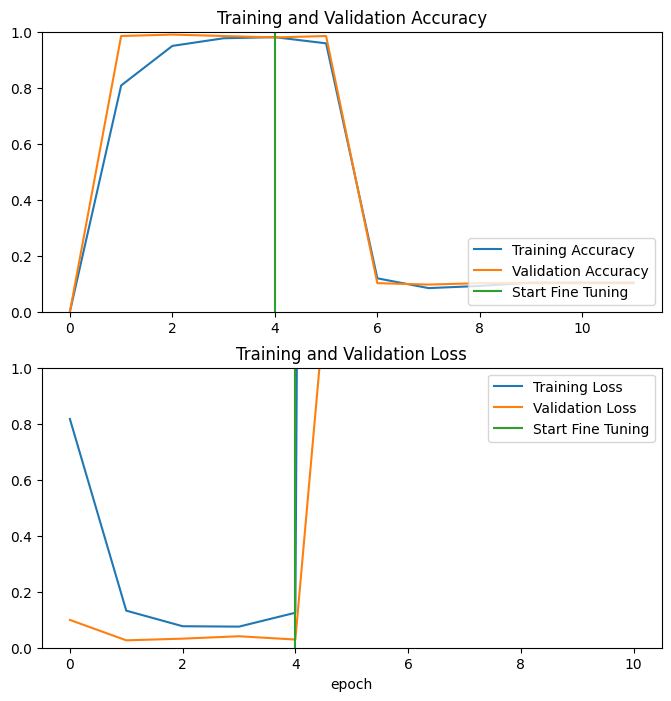

In [94]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()